In [1524]:
# Importing the libraries

# General DS libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Machine Learning pre-processing libraries
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler

# Machine Learning analysis libraries
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# Machine Learning algorithm post-processing libraries
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn import model_selection
import sklearn.metrics

In [1525]:
# Load stored DataFrame from data wrangling
%store -r recent_nyc

# Prediction of Permit Issue Times

## Table of Contents
* [9. Framing the Problem](#9.-Framing-the-Problem)
* [10. Data Transformation](#10.-Data-Transformation)
* [11. Compare Machine Learning Models](#11.-Compare-Machine-Learning-Models)
* [12. Feature Importance](#12.-Feature-Importance)
* [13. Class Imbalance](#13.-Class-Imbalance)
* [14. Model Enhancements](#14.-Model-Enhancements)
* [15. Resampling (Optional)](#15.-Resampling-(Optional))
* [16. Limitations](#16.-Limitations)
* [17. Future Work](#17.-Future-Work)
* [18. Major Findings and Client Recommendations](#18.-Major-Findings-and-Client-Recommendations)
* [19. Acknowledgements](#19.-Acknowledgements)

## 9. Framing the Problem

Supervised classification algorithms will be used to classify the issue times into time ranges. A classification approach is used because regression-based approaches are sensitive to outliers, which are present in many of the independent variables.

The number of classes could largely affect model performance due to class imbalance. Binary class or three-class outcomes were considered for this project, although more classes may be used. The class time ranges were chosen to reduce class imbalance issues if possible, more specifically:

- Binary outcome:
    - class 0: 1 month to 2 months
    - class 1: > 2 months
- Multi-class outcome:
    - class 0: 1 month to 3 months
    - class 1: 3 months to 6 months
    - class 2: >6 months

Some classification algorithms to be explored include:
- Logistic Regression (LR)
- K-Nearest Neighbors (KNN)
- Classification and Regression Trees (CART)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Naive Bayes (NB)
- Gradient Boosted Trees (XGBoost)

##  10. Data Transformation

Let's first perform some feature engineering and data transformation. The filing and job start day and month are added as new features to consider.

In [1526]:
def get_day(row):
    """Extract day of the week"""
    day = row.dayofweek
    return day

def get_month(row):
    """Extract month"""
    month = row.month
    return month

# Convert to datetime
recent_nyc['job_start_date'] = pd.to_datetime(recent_nyc['job_start_date'],errors='coerce')

# Filing date feature engineering
recent_nyc['filing_day'] = recent_nyc.filing_date.apply(get_day)
recent_nyc['filing_month'] = recent_nyc.filing_date.apply(get_month)

# Job start date feature engineering
recent_nyc['job_start_day'] = recent_nyc.job_start_date.apply(get_day)
recent_nyc['job_start_month'] = recent_nyc.job_start_date.apply(get_month)

Let's transform the datatypes for efficiency based on domain knowledge and prior insight from the EDA stage.

In [1527]:
# Convert to category data type
category_data_types = ['residential', 'bldg_type', 'permit_status', 'filing_status', 'permit_subtype', 
                       'permittee_license_type', 'nonprofit', 'nta_name', 'council_district', 
                       'census_tract', 'filing_month', 'filing_day', 'block', 'lot', 'community_board', 
                       'zip_code', 'job_start_month', 'job_start_day']
def convert_datatype(df, lst, dtype, num=False):
    if num==False:
        for i in lst:
            df[i] = df[i].astype(dtype)
    else:
        for i in lst:
            df[i] = pd.to_numeric(df['i'], errors='coerce')

convert_datatype(recent_nyc, category_data_types, dtype='category')

# Convert to DateTime data type
recent_nyc.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17589 entries, 1 to 1107938
Data columns (total 32 columns):
borough                   17589 non-null category
job_doc_num               17589 non-null int64
job_type                  17589 non-null category
block                     17589 non-null category
lot                       17589 non-null category
community_board           17574 non-null category
zip_code                  17587 non-null category
bldg_type                 17586 non-null category
residential               10008 non-null category
work_type                 13825 non-null category
permit_status             17533 non-null category
filing_status             17589 non-null category
permit_type               17589 non-null category
permit_subtype            9717 non-null category
filing_date               17589 non-null datetime64[ns]
issuance_date             17589 non-null datetime64[ns]
expiration_date           17589 non-null datetime64[ns]
job_start_date           

NaNs will cause issues with many machine learning algorithms. I've decided to create dummy variables for the NaNs in the categorical variables. For the continuous variables, more specifically latitude and longitude, I've decided to impute these values since there are only 23 out of 17589 records.

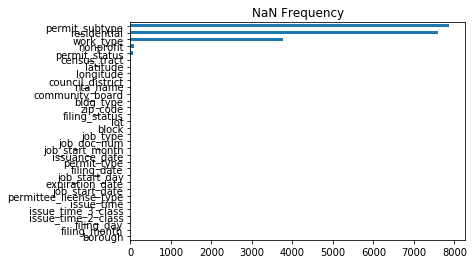

In [1528]:
_ = pd.Series(recent_nyc.isnull().sum()).sort_values(ascending=True).plot.barh(width=0.5)
_ = plt.title('NaN Frequency')
plt.show()

In [1529]:
recent_nyc.isnull().sum()

borough                   0   
job_doc_num               0   
job_type                  0   
block                     0   
lot                       0   
community_board           15  
zip_code                  2   
bldg_type                 3   
residential               7581
work_type                 3764
permit_status             56  
filing_status             0   
permit_type               0   
permit_subtype            7872
filing_date               0   
issuance_date             0   
expiration_date           0   
job_start_date            0   
permittee_license_type    0   
nonprofit                 88  
latitude                  23  
longitude                 23  
council_district          23  
census_tract              23  
nta_name                  23  
issue_time                0   
issue_time_3_class        0   
issue_time_2_class        0   
filing_day                0   
filing_month              0   
job_start_day             0   
job_start_month           0   
dtype: i

In [1530]:
X = pd.get_dummies(recent_nyc.loc[:, ['borough','job_type', 'bldg_type', 'work_type', 'permit_status',
                                        'filing_status', 'permit_type', 'permit_subtype',
                                        'permittee_license_type', 'nonprofit',
                                        'council_district', 'filing_day', 'filing_month', 'job_doc_num',
                                        'job_start_day', 'job_start_month', 'latitude', 'longitude']], drop_first=True, dummy_na=True)
Y = recent_nyc['issue_time_2_class'].values
# Y = recent_nyc['issue_time_3_class'].values
X.info()
X.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17589 entries, 1 to 1107938
Columns: 155 entries, job_doc_num to job_start_month_nan
dtypes: float64(2), int64(1), uint8(152)
memory usage: 3.1 MB


,job_doc_num,latitude,longitude,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,borough_nan,job_type_A2,job_type_A3,...,job_start_month_4.0,job_start_month_5.0,job_start_month_6.0,job_start_month_7.0,job_start_month_8.0,job_start_month_9.0,job_start_month_10.0,job_start_month_11.0,job_start_month_12.0,job_start_month_nan
1,1,40.686314,-73.996264,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,40.644270,-73.958834,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,40.644270,-73.958834,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
8,1,40.636519,-74.022731,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
9,1,40.645788,-73.944217,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


Let's first prepare our data for machine learning by transforming the categorical data by creating dummy variables. We do this using pd.get_dummies and setting 'drop_first=True' to avoid the dummy variable trap, i.e. we avoid feeding redundant information to the algorithm.

Now that all of the data is in numerical form we have some options to appropriately transform the data to ensure that the machine learning algorithms provide appropriate results. We may:
- Rescale data
- Standardize data
- Normalize data
- Binarize data

For this project, I will standardize the data from the test and train splits.

In [1531]:
X_columns = X.columns
imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
X = imputer.fit_transform(X)
X = pd.DataFrame(X)
X.columns = X_columns

In [1532]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

# Scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## 11. Compare Machine Learning Models

Before tuning hyperparameters and other optimizations, it'd be a good idea to figure out which algorithm may work best for our given problem. Let's try a mixture of modeling types, e.g. linear and nonlinear functions or parametric and
nonparametric.

DUMMY: 0.529908 (0.012118)
LR: 0.630958 (0.014571)
KNN: 0.610186 (0.015115)
CART: 0.695544 (0.039398)
NB: 0.605941 (0.023196)
SVM: 0.667953 (0.016043)
RF: 0.669926 (0.015679)


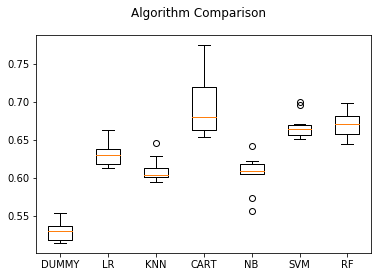

In [1547]:
# Load dataset
X_compare = X_train
Y_compare = Y_train

# Prepare configuration for cross validation test harness
seed = 7

# Prepare models
models = []
models.append(('DUMMY', DummyClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_compare, Y_compare, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 12. Feature Importance

After splitting, let's identify the most important features in our dataset that contribute most to our prediction variable. Irrelevant features would decrease accuracy especially for linear algorithms, e.g. linear regression and logistic regression. Here are some other benefits:

- Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
- Improves Accuracy: Less misleading data means modeling accuracy improves.
- Reduces Training Time: Less data means that algorithms train faster.

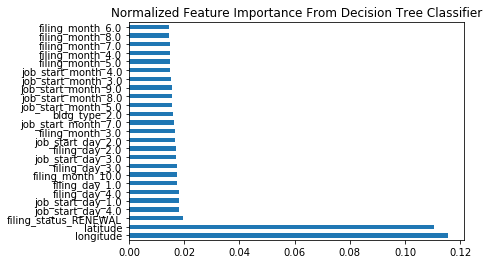

In [1534]:
classifier = RandomForestClassifier(n_jobs = -1)
classifier.fit(X_train, Y_train)
feature_importance = pd.DataFrame(classifier.feature_importances_)
# feature_importance = feature_importance/np.max(feature_importance.iloc[:, 0])
feature_importance = feature_importance

feature_importance.index = X.columns
n_largest = feature_importance.nlargest(25, 0)


n_largest.plot.barh(width=0.5, legend=False)
_ = plt.title('Normalized Feature Importance From Decision Tree Classifier')
plt.show()

## 13. Class Imbalance

The classes were purposefully chosen to reduce the effects of class imbalance.

Class 0: 11057
Class 1: 6532


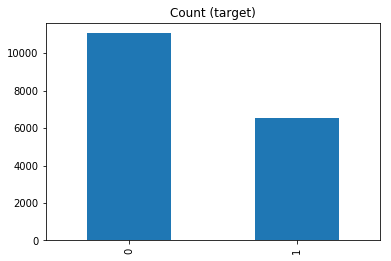

In [1535]:
target_count = recent_nyc.issue_time_2_class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
target_count.plot(kind='bar', title='Count (target)')
plt.show()

Class 0: 6128
Class 1: 5697
Class 2: 5764


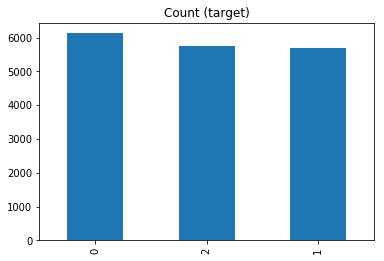

In [1536]:
target_count = recent_nyc.issue_time_3_class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])

target_count.plot(kind='bar', title='Count (target)')
plt.show()

## 14. Model Enhancements

Based on the initial non-optimized runs of several kinds of algorithms in section 11, I will now focus on running tree-based classifiers as they seem to have the best initial metrics.

Some classification metrics to consider include:
* **Classification Accuracy**: Number of correct predictions made as a ratio of all predictions made
    * Note: Suitable when there are an equal number of observations in each class. Predictions and prediction errors are equally important  
* **Logarithmic Loss**: Evaluates the predictions of probabilities of membership to a given class. The scalar probability between 0 and 1 can be seen as a measure of confidence for a prediction by an algorithm. Predictions that are correct or incorrect are rewarded or punished proportionally to the confidence of the prediction.
    * Note: Smaller logloss is better with 0 representing a perfect logloss.
* **Area Under ROC Curve**: Evaluates a model's ability to discriminate between positive and negative classes
    * Note: Used for binary classification problems. 1.0 = Perfect, 0.5 = Random
* **Confusion Matrix**: Presents the accuracy of a model with two or more classes
* **Classification Report**: Displays the precision, recall, F1-score and support for each class

Starting with a Dummy Classifier, we may use this as a benchmark for other supervisied classification algorithms.

In [1537]:
# K-Fold Cross-Validation
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
model = DummyClassifier()
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

neg_log_loss : -15.922 (0.455)
accuracy : 0.537 (0.015)
Classification Report: 
              precision    recall  f1-score   support

          0       0.63      0.63      0.63      2730
          1       0.39      0.39      0.39      1668

avg / total       0.54      0.54      0.54      4398
 



The Receiver Operator Characteristic (ROC) curve shows an almost 45 degree line, which is to be expected when a classifier is as good as flipping a coin.

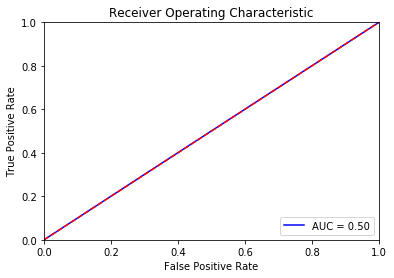

In [1538]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = model.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random forest classifiers are an ensemble of decision tree classifiers. They have the key advantages of computational efficiency and an ability to handle high dimensions well. Because randomness is introduced in the selection of records and features, the random forest reduces overfitting, which decision trees are more prone.

In [1539]:
param_grid = {
    'n_estimators': [10, 100, 200, 300]
}

# K-Fold Cross-Validation
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
model = RandomForestClassifier()
model = GridSearchCV(estimator = model, param_grid = param_grid, 
                     cv = num_folds, n_jobs = -1)
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

neg_log_loss : -0.565 (0.011)
accuracy : 0.691 (0.016)
Classification Report: 
              precision    recall  f1-score   support

          0       0.69      0.92      0.79      2730
          1       0.70      0.32      0.44      1668

avg / total       0.69      0.69      0.65      4398
 



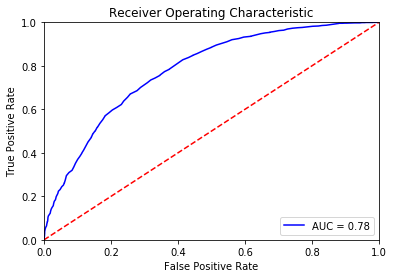

In [1540]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = model.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Gradient Boosted Trees are sequentially grown trees that aims to improve predictions from previously grown trees. In boosting, because the growth of a particular tree takes into account the other trees that have already been grown, smaller trees are typically sufficient. Using smaller trees can aid in interpretability as well; for instance, using stumps leads to an additive model.

Random Forest on the other hand typically does not use decision stumps, but uses rather complex trees.

https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf

In [1546]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# K-Fold Cross-Validation
num_folds = 10
seed = 42
kfold = KFold(n_splits=num_folds, random_state=seed)
model = XGBClassifier()

model = GridSearchCV(estimator = model, param_grid = param_grid, 
                     cv = num_folds, n_jobs = -1)
scoring = ['neg_log_loss', 'accuracy']
for score in scoring:
    results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    print(score,": %.3f (%.3f)" % (results.mean(), results.std()))

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
report = classification_report(Y_test, Y_pred)
print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_
#print(best_accuracy, best_parameters)
#cm = confusion_matrix(y_test, y_pred)
#print('Confusion Matrix: \n', cm, '\n')
#print('Classification Report: \n', classification_report(y_test,y_pred), '\n')
#print('Accuracy Score: %.10f '% sklearn.metrics.accuracy_score(y_test, y_pred))

neg_log_loss : -0.551 (0.016)
accuracy : 0.714 (0.022)
Classification Report: 
              precision    recall  f1-score   support

          0       0.71      0.92      0.80      2730
          1       0.74      0.40      0.52      1668

avg / total       0.72      0.72      0.69      4398
 



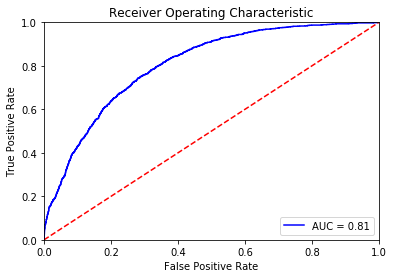

In [1542]:
# Visualize the Receiver Operator Curve (ROC)
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds of the classification
#.90-1 = excellent (A)
#.80-.90 = good (B)
#.70-.80 = fair (C)
#.60-.70 = poor (D)
#.50-.60 = fail (F)
probs = model.predict_proba(X_test) # returns probability estimates for test set 
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 15. Resampling (Optional)

Resampling may be used if classes are extremely unbalanced. The binary dependent variable, however, was engineered to reduce the effects of class imbalance.

In [1543]:
# # Oversampling on training set
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler()
# X_ros, Y_ros = ros.fit_sample(X_train, Y_train)

# # Undersampling on training set
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler()
# X_rus, Y_rus = rus.fit_sample(X_train, Y_train)

# # Synthetic Minority Over-sampling Technique (SMOTE) on training set
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(ratio='minority')
# X_sm, Y_sm = smote.fit_sample(X_train, Y_train)

# # Synthetic Minority Over-sampling Technique (SMOTE) with Tomek Links on training set
# from imblearn.combine import SMOTETomek
# smt = SMOTETomek(ratio='auto')
# X_smt, Y_smt = smt.fit_sample(X_train, Y_train)

# # K-Fold Cross-Validation
# num_folds = 5
# seed = 7
# kfold = KFold(n_splits=num_folds, random_state=seed)
# model = RandomForestClassifier()

# # Create resampling list to loop over
# X_resamples = [(X_ros, Y_ros, 'Oversampling'), (X_rus, Y_rus, 'Undersampling'), 
#                (X_sm, Y_sm, 'SMOTE'), (X_smt, Y_smt, 'SMOTETomek')]

# # Extract accuracy, before/after class value counts, and classification report for each resampling technique
# for X_resample in X_resamples:
#     X_res, Y_res, technique = X_resample
#     results = cross_val_score(model, X_res, Y_res, cv=kfold, scoring='accuracy')
#     print(technique)
#     print(score,": %.3f (%.3f)" % (results.mean(), results.std()))
#     model.fit(X_res, Y_res)
#     print ("Distribution of class labels before resampling \n{}".format(Counter(Y_train)))
#     print ("Distribution of class labels after resampling \n{}".format(Counter(Y_res)))
#     Y_pred = model.predict(X_test)
#     report = classification_report(Y_test, Y_pred)
#     print('Classification Report: \n', classification_report(Y_test, Y_pred), '\n')

## 16. Limitations

- The building permit data did not include the cost of the proposed work. It may be the case that proposed work with large economic value to the city may get pushed ahead of the queue.

- Building permit expeditors typically reduces turnaround time for permit applications, which may introduce bias into the dataset.

## 17. Future Work

- Investigate framing the problem into a multi-class problem.

- Try incorporating other related datasets that may boost the signal, such as population and houeshold income datasets to better understand why location is a strong predictor. 


## 18. Major Findings and Client Recommendations

**Real Estate Developers/ Homeowners:**

1) Location, job start time and filing time are the most important features in building issue times. 

2) Use the Gradient Boosted Trees algorithm to predict building permit issue times for non-trivial work items, e.g. new buildings and major alterations that will change the use, egress, or occupancy of the building.

3) For minor work, such as electrical work and demolition, involving single building departments expect issue times of less than a month.

**NYC Building Department:**

Minimal information is provided about issue times on the website. One solution is to provide a web service that allows applicants to take an online survey, which provides an building permit issue time range based on what was checked on the survey. The issue time range could be based on statistics from the past 5 years.


## 19. Acknowledgements

I would like to thank Springboard, especially my mentor Scott Clendaniel for the advice and support throughout the capstone project.

Sources:
- https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
- https://elitedatascience.com/imbalanced-classes
- https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
- https://www.kaggle.com/muonneutrino/new-york-city-census-data/version/2#nyc_census_tracts.csv
- https://transition.fcc.gov/form477/Geo/more_about_census_tracts.pdf
- https://www.featuretools.com/
- https://beckernick.github.io/oversampling-modeling/
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- http://kseow.com/guides/
- https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/